#TXT35系統,feature_v4,ver0.0.8から移植

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
data_dir = "F:/TARGET frontier/TXT35/"
data_name = "train"
tail = "fe1"
train_data = pd.read_csv(data_dir+data_name+tail+".csv",encoding="shift-jis",dtype={'レースID(新)':str})

In [3]:
pd.set_option('display.max_columns', 100)
train_data.head()

,レースID(新),場所,芝・ダ,距離,クラス名,馬場状態,出走頭数,騎手,枠番,性別,年齢,キャリア,斤量,馬体重,馬体重増減,間隔,休み明け〜戦目,種牡馬,父タイプ名,所属,調教師,入線順位,確定着順,着差,単勝オッズ,複勝オッズ下限,複勝オッズ上限,複勝配当,前走レースID(新),前走場所,前芝・ダ,前距離,前クラス名,前走馬場状態,前走出走頭数,替,前騎手,前走枠番,前走脚質,前走斤量,前走Ave-3F,前走上り3F,前走上り3F順,前走RPCI,前PCI,前好走,前走入線順位,前走確定着順,前走着差タイム,前走PCI3,前走単勝オッズ,場所距離芝ダ,前走場所距離芝ダ
0,201512270605081112,2,2,1200,2,3,16,427,6,2,3,13,56.0,492,-4.0,6.0,5.0,572,8,0,323,1,1,0.0,5.4,1.9,2.7,190.0,201511140505031003,13,2,1400.0,2,2,15.0,0,285,2.0,3,54.0,37.2,33.9,10.0,58.2,59.7,0,8.0,8.0,0.2,59.53,14.6,63,42
1,201512270605081111,2,2,1200,2,3,16,67,6,1,3,10,54.0,466,-12.0,3.0,3.0,452,8,0,322,2,2,0.0,2.8,1.3,1.6,130.0,201512060704020613,1,2,1200.0,1,3,18.0,1,67,7.0,3,54.0,34.5,34.6,3.0,46.9,49.7,0,1.0,1.0,0.0,48.80,2.2,63,15
2,201512270605081106,2,2,1200,2,3,16,209,3,2,3,9,56.0,478,6.0,5.0,2.0,607,5,1,210,3,3,0.2,6.2,1.8,2.5,180.0,201511210805051217,3,2,1200.0,2,3,18.0,0,137,8.0,2,56.0,34.5,34.4,9.0,48.0,50.3,0,7.0,7.0,0.4,50.13,28.6,63,188
3,201512270605081108,2,2,1200,2,3,16,338,4,1,5,17,55.0,484,-4.0,2.0,4.0,91,1,1,334,4,4,0.3,6.6,1.7,2.5,0.0,201512130605040911,2,2,1200.0,2,2,16.0,1,338,6.0,2,53.0,34.1,34.4,3.0,46.3,49.1,0,3.0,3.0,0.0,48.17,19.1,63,111
4,201512270605081116,2,2,1200,2,3,16,387,8,1,3,15,54.0,440,-6.0,2.0,4.0,325,4,1,162,5,5,0.3,33.9,6.3,9.7,0.0,201512130605040904,2,2,1200.0,2,2,16.0,0,213,2.0,5,53.0,33.6,36.4,15.0,46.3,42.3,1,13.0,13.0,1.5,48.17,8.6,63,111


In [4]:
train_data.columns

Index(['レースID(新)', '場所', '芝・ダ', '距離', 'クラス名', '馬場状態', '出走頭数', '騎手', '枠番', '性別',
       '年齢', 'キャリア', '斤量', '馬体重', '馬体重増減', '間隔', '休み明け〜戦目', '種牡馬', '父タイプ名',
       '所属', '調教師', '入線順位', '確定着順', '着差', '単勝オッズ', '複勝オッズ下限', '複勝オッズ上限',
       '複勝配当', '前走レースID(新)', '前走場所', '前芝・ダ', '前距離', '前クラス名', '前走馬場状態',
       '前走出走頭数', '替', '前騎手', '前走枠番', '前走脚質', '前走斤量', '前走Ave-3F', '前走上り3F',
       '前走上り3F順', '前走RPCI', '前PCI', '前好走', '前走入線順位', '前走確定着順', '前走着差タイム',
       '前走PCI3', '前走単勝オッズ', '場所距離芝ダ', '前走場所距離芝ダ'],
      dtype='object')

In [70]:
use_train_columns = ['場所', '芝・ダ', '距離','馬場状態', '騎手', '枠番', '性別', '年齢', 'キャリア',
       '斤量', '間隔', '休み明け〜戦目', '種牡馬', '父タイプ名', '調教師', '前走場所', '前芝・ダ', '前距離',
       '前走馬場状態', '前騎手', '前走枠番', '前走脚質', '前走斤量', '前走Ave-3F',
       '前走上り3F', '前走PCI3', '前走RPCI', '前PCI', '前好走', '前走着差タイム',
       '前走単勝オッズ', '単勝オッズ', '出走頭数','場所距離芝ダ', '前走場所距離芝ダ']

In [71]:
#test_data
test_data = pd.read_csv(data_dir+"predict"+tail+".csv",encoding="shift-jis",dtype={'レースID(新)':str})
test_x = test_data[use_train_columns]
test_y = test_data["入線順位"]

In [72]:
train_x = train_data[use_train_columns]
train_y = train_data["入線順位"]

In [73]:
#チューニング済みパラメータ(etaのみ手動)
params = {'colsample_bytree': 0.65, 
          'gamma': 0.013439667332810353, 
          'max_depth': 5, 
          'min_child_weight': 2.663317188920419, 
          'subsample': 0.9, 
          'booster': 'gbtree', 
          'objective': 'reg:squarederror', 
          'eta': 0.01, 
          'alpha': 0.0, 
          'lambda': 1.0, 
          'random_state': 71}

In [74]:
#これがないとエラー履くので注意
train_y.fillna(10,inplace=True) #無ければ10位に
test_y.fillna(10,inplace=True)

In [75]:
scores = []
histories = []
models = []
y = pd.Series()
kf = KFold(n_splits=4,shuffle=False)
for tr_idx,va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    dtrain = xgb.DMatrix(tr_x,label=tr_y)
    dvalid = xgb.DMatrix(va_x,label=va_y)
    watchlist = [(dtrain,"train"),(dvalid,"eval")]
    evals_result = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        early_stopping_rounds=100,
        evals=watchlist,
        evals_result=evals_result,
        verbose_eval=500
    )
    models.append(model)
    histories.append(evals_result)
    va_pred = model.predict(dvalid)
    va_y.fillna(0.5,inplace=True)
    score = mean_squared_error(va_y,va_pred)
    score = np.sqrt(mean_squared_error(va_y,va_pred)) #rmse
    scores.append(score)
    
    #evaluationさせる
    #全部のfoldについてyに入れておいて、
    y_pred_proba = model.predict(dvalid)
    y = pd.concat([y,pd.Series(y_pred_proba)])


output = train_data
output = output.assign(ya=y.values)
output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/kfeval.csv",index=False,encoding="shift-jis")
    
print(*scores)
print(np.mean(scores))

[0]	train-rmse:8.4926	eval-rmse:8.57373
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:3.49116	eval-rmse:3.55379
[1000]	train-rmse:3.44926	eval-rmse:3.53625
[1500]	train-rmse:3.42291	eval-rmse:3.53256
[2000]	train-rmse:3.40043	eval-rmse:3.53102
Stopping. Best iteration:
[2309]	train-rmse:3.38751	eval-rmse:3.53061

[0]	train-rmse:8.49105	eval-rmse:8.57719
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:3.48787	eval-rmse:3.56238
[1000]	train-rmse:3.4472	eval-rmse:3.54663
[1500]	train-rmse:3.42106	eval-rmse:3.54143
[2000]	train-rmse:3.39924	eval-rmse:3.53878
[2500]	train-rmse:3.37851	eval-rmse:3.53699
[3000]	train-rmse:3.35845	eval-rmse:3.53584
[3500]	train-rmse:3.33954	eval-rmse:3.53506
[4000]	train-rmse:3.32033	eval-rmse:3.53425
Stopping. Best iteration:
[4008]	tr

## 学習結果(RMSE)メモ  
ベースラインoptなし：3.50597049
optあり：3.506764  
特徴量減少：3.500605  
min_child_weight=3:3.500535
そのまま更に特徴量減少：3.500551
全特徴量入れ：4.9545←ロスこそいいもののこれと言って利益は出ない。
実際に影響がなさそうな特徴と、全くgainがない特徴料を除く：3.4976 ←利益なし
ver0.0.8の再現(パラメータも):3.497957
完全再現(le違いあり)するも、近い結果は得られず。

In [31]:
#学習結果のプロット
%matplotlib inline
def plot_loss(evals_result, title):
    train_metric = evals_result['train']['rmse']
    plt.plot(train_metric, label='train rmse')
    eval_metric = evals_result['eval']['rmse']
    plt.plot(eval_metric, label='eval rmse')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.xlabel('rounds')
    plt.ylabel('rmse')
    plt.show()

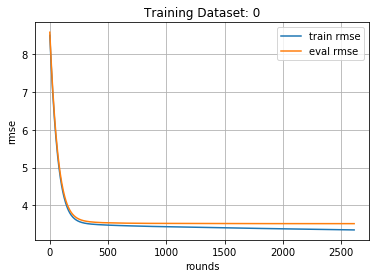

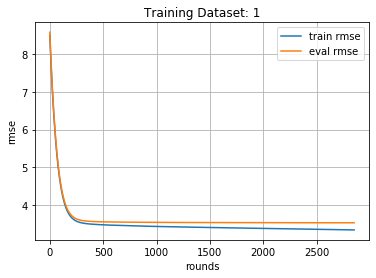

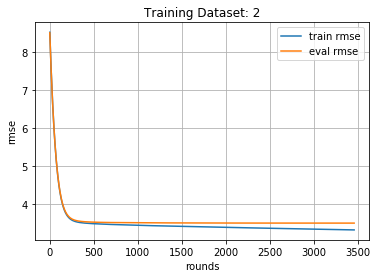

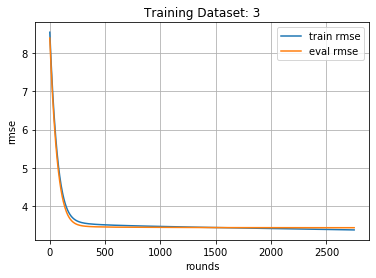

In [32]:
for i in range(4):
    plot_loss(histories[i],f'Training Dataset: {i}')

In [76]:
test_length = len(test_data)
predict = np.array([0.0]*test_length)
dtest = xgb.DMatrix(test_x,label=test_y) #本来は学習に使用していないデータにする
for i in range(4):
    y_pred_proba = models[i].predict(dtest)
    predict += y_pred_proba

predict /= 4

In [77]:
y = pd.DataFrame(predict,columns=["y'"])
output = test_data #ここも書き換えること

output = pd.concat([output,y],axis=1)

output["複勝配当"] = output["複勝配当"].astype("int64")
output.to_csv("C:/programs/HRP/neweval10.csv",index=False,encoding="shift-jis")

In [61]:
fscore = model.get_score(importance_type="total_gain")
fscore = sorted([(k,v) for k,v in fscore.items()] ,key=lambda tpl: tpl[1], reverse = True)
print(*fscore[:20])

('単勝オッズ', 33212522.952994376) ('出走頭数', 4689618.884631084) ('前走入線順位', 4165082.0746064624) ('前走単勝オッズ', 2656277.25252943) ('間隔', 707925.1255314576) ('前走着差タイム', 602185.5382902332) ('前走Ave-3F', 521306.3033047185) ('前PCI', 382406.6958488964) ('前走脚質', 373761.75530317647) ('前走上り3F', 349259.53869382676) ('騎手', 322824.412093532) ('前距離', 322368.2799826102) ('前クラス名', 322162.0555592839) ('前走PCI3', 319288.70512466494) ('キャリア', 295609.01438570395) ('種牡馬', 282387.1557997404) ('前好走', 272289.59388645) ('クラス名', 253161.12052995947) ('前走出走頭数', 242565.92828888504) ('距離', 241699.66342724624)


In [46]:
#全体を100[%]とした時の重要度
mother = sum([j for i,j in fscore])
for i,j in fscore[:30]:
    print(i,round((j/mother)*100,2))

単勝オッズ 66.54
出走頭数 8.04
前走入線順位 3.96
前走単勝オッズ 2.56
間隔 1.56
前走Ave-3F 1.24
前走上り3F順 1.24
前走PCI3 0.97
前PCI 0.93
騎手 0.92
前走着差タイム 0.89
種牡馬 0.85
調教師 0.74
前走上り3F 0.72
キャリア 0.71
前騎手 0.67
前走脚質 0.62
前距離 0.61
場所距離芝ダ 0.59
前クラス名 0.59
距離 0.52
休み明け〜戦目 0.49
前走場所距離芝ダ 0.48
前走出走頭数 0.46
クラス名 0.45
枠番 0.42
芝・ダ 0.29
年齢 0.26
斤量 0.26
前走枠番 0.23


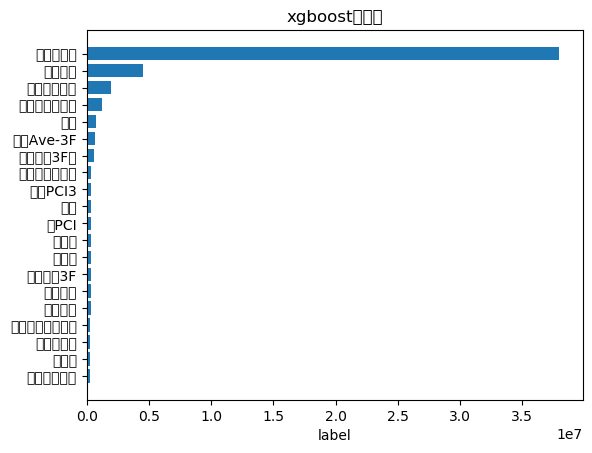

In [17]:
slen = 20
label = []
weight = []
for i,j in fscore[:slen]:
    label.append(i)
    weight.append(j)

plt.rcdefaults() #横棒グラフモード
fig, ax = plt.subplots()
y_pos = np.arange(slen)
ax.barh(y_pos, weight,align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(label)
ax.invert_yaxis()
ax.set_xlabel('label')
ax.set_title('xgboost特徴量')
plt.show()
    

In [18]:
#save models
import pickle
with open('xgmachina_ver0.0.7.pickle', mode='wb') as fp:
    pickle.dump(models, fp)

In [19]:
#import models
"""import pickle
with open('xgmachina_ver0.0.6.pickle', mode='rb') as fp:
    models = pickle.load(fp)"""

"import pickle\nwith open('xgmachina_ver0.0.6.pickle', mode='rb') as fp:\n    models = pickle.load(fp)"